# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Dataset Overview
The dataset comprises two sets of data. Initially, we utilized water level data from the weather station in St. Pauli. This dataset records water levels minutely and has been collected since 1999. It is accessible for free through [hydroonline.hpanet.de](https://).

Additionally, we incorporated wind data from the Island Helgoland in the German bay. This dataset records wind data hourly and has been collected since 1959. It is freely available at [opendata.dwd.de](https://).

After cleaning and merging these datasets, our combined dataset contained 196,521 data points, which spans approximately 22 years.

In [6]:
# Import libaries
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

### Tide Data

#### Import The Data
The tide data is only available in chunks of one year. These have to be stored in one file.

In [7]:
# Setting file path
tide_folder_path = r'C:\Users\Hanne\Documents\Studium\Semester 4\Machine Learning\Projekt\Pegelstände'#r'1_DatasetCharacteristics/Data'

In [8]:
# Define header and footer lenght
skip_rows = 18
skip_footer = 3

# Define column names
column_names = ['Date_Time', 'Water_Level', 'Reference', 'OffsetToNN']

# List to store individual DataFrames
dfs = []

# Iterate through files in the folder
for filename in os.listdir(tide_folder_path):
    if filename.endswith(".csv"):  # Assuming all files have the .csv extension
        file_path = os.path.join(tide_folder_path, filename)
        df = pd.read_csv(file_path,skipfooter = skip_footer,skiprows =  skip_rows,sep=';', names=column_names , decimal=',', engine= "python")
        dfs.append(df)

# Concatenate the tide data along the rows
tide_data_raw = pd.DataFrame(pd.concat(dfs, axis=0, ignore_index=True))

In [9]:
# Extract time and water level columns
tide_data = tide_data_raw[['Date_Time', 'Water_Level']]
print(tide_data.head())
lenght = len(tide_data['Date_Time'])
print(f'\nThe total length of the tide data is: {lenght} minutes')

             Date_Time  Water_Level
0  1999-01-01 00:00:00          NaN
1  1999-01-01 00:01:00          NaN
2  1999-01-01 00:02:00          NaN
3  1999-01-01 00:03:00          NaN
4  1999-01-01 00:04:00          NaN

The total length of the tide data is: 13044960 minutes


#### Cleaning The Data

In [10]:
# Filter out obvious outliers
Pegelstand = tide_data.columns[1]
Date = tide_data.columns[0]
tide_data.loc[(tide_data[Pegelstand] > 650) | (tide_data[Pegelstand] < -650), Pegelstand] = np.nan
tide_data.loc[Date] = tide_data[Date].astype('datetime64[ns]')
tide_data = tide_data.iloc[:-1]

C:\Users\Hanne\AppData\Local\Temp\ipykernel_8100\1073088871.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tide_data.loc[Date] = tide_data[Date].astype('datetime64[ns]')


In [11]:
# Define function that filters out outliers using the gradient of the data
def clean_outliers(df_input, threshold):
    # Calculate the gradient
    gradient = np.gradient(df_input)

    # Identify and remove outliers based on the gradient
    outliers = df_input[np.abs(gradient) > threshold]
    df_cleaned = df_input.copy()

    # Set outliers to NaN
    df_cleaned.loc[outliers.index] = np.nan


    return df_cleaned, outliers

# Defining threshold for gradient cleaning
threshold = 40

# Load in tide data
tide = tide_data[Pegelstand]

# Clean outliers using the gradient method
tide,outliers =  clean_outliers(tide,threshold)

In [12]:
# Filter data to get hourly data, in order to match it to the wind data
tide_60 = tide[::60]
time_tide = tide_data['Date_Time'].values[::60]

In [13]:
# Defining maximum lenght of interpolated gaps
max_nan = 6

# Interpolate gaps smaller than max_nan
tide_60_inter = tide_60.interpolate(method = 'linear', limit = max_nan).values

### Wind Data

#### Import Data

In [14]:
wind_path = r"C:\Users\Hanne\Documents\Studium\Semester 4\Machine Learning\Projekt\Helgoland\Wind_data.txt"#r'1_DatasetCharacteristics/Data/Wind_data.txt'
wind_data = pd.read_csv(wind_path, delimiter=";")

In [15]:
# Extract wind speed, direction and time out of the wind data
wind_speed_raw = wind_data["   F"].values
wind_direction_raw = wind_data["   D"].astype("float").values
time_wind_raw = wind_data["MESS_DATUM"].astype("int")

#### Cleaning The Data

In [16]:
# Find all missing values in the data which are encoded as -999
nan_index = []
for i,v in enumerate(wind_direction_raw):
    if v == -999:
        nan_index.append(i)

for i,v in enumerate(wind_speed_raw):
    if v == -999:
        nan_index.append(i)

# Replace the missing values with nan values for consistency
wind_speed_raw[nan_index] = np.nan
wind_direction_raw[nan_index] = np.nan

In [17]:
# The time data of the wind data has missing values, so complete time series are missing. Here we define a function which imputs the correct time data at a given point if 
# It is missing
def fill_missing_values(integers, values1, values2):
    # Convert time values to pandas datetime objects
    datetime_integers = pd.to_datetime(integers, format='%Y%m%d%H')

    # Find the time in hours from the start
    hours_from_start = (datetime_integers - datetime_integers.min()) / np.timedelta64(1, 'h')

    # Create a continuous array of hours
    continuous_hours = np.arange(hours_from_start.min(), hours_from_start.max() + 1)

    # Create arrays of NaNs with the same length as continuous_hours
    nan_values1 = np.full_like(continuous_hours, np.nan, dtype=float)
    nan_values2 = np.full_like(continuous_hours, np.nan, dtype=float)

    # Find the indices where the original hours match the continuous range
    indices = np.searchsorted(continuous_hours, hours_from_start)

    # Fill in the nan_values arrays at the appropriate indices with the original values
    nan_values1[indices] = values1
    nan_values2[indices] = values2

    # Convert continuous_hours back to the desired integer format
    continuous_integers = (datetime_integers.min() + pd.to_timedelta(continuous_hours, unit='h')).strftime('%Y%m%d%H').astype(int)
    continuous_integers = pd.to_datetime(continuous_integers, format='%Y%m%d%H')

    return continuous_integers.values, nan_values1, nan_values2

# Insert the missing time value in the time data and insert nan values in the wind_direction and the wind_speed data 
time_wind, wind_speed, wind_direction = fill_missing_values(time_wind_raw,wind_speed_raw,wind_direction_raw)

In [18]:
# Define function which interpolates all gaps of nans with a certain maximum lenght 
def interpolate_nans(series, max_gap_length,data_type):
    df = pd.DataFrame({'values': series})
    df['filled'] = df['values'].interpolate(limit=max_gap_length)

    return df['filled'].astype(data_type).values

# Interpolate all the gaps with a maximum number of missing values equal to 6
wind_speed = interpolate_nans(wind_speed, max_nan,"float")
wind_direction = interpolate_nans(wind_direction, max_nan,"float")

In [19]:
# Define function that transforms the wind from speed and direction to vector components
def wind_speed_components(speed, direction):
    # Convert direction to radians
    direction_rad = np.radians(direction)

    # Calculate x and y components
    speed_x = speed * np.sin(direction_rad)  # Negative due to different coordinate system
    speed_y = speed * np.cos(direction_rad)  # Negative due to different coordinate system

    return speed_x, speed_y

# Transform wind into vector
wind_zonal, wind_meridional = wind_speed_components(wind_speed, wind_direction)

## Merging The Datasets



In [20]:
time_tide = time_tide.astype('datetime64[s]')
time_wind = time_wind.astype('datetime64[h]')
print(time_wind)

['1959-01-01T00' '1959-01-01T01' '1959-01-01T02' ... '2022-12-31T21'
 '2022-12-31T22' '2022-12-31T23']


In [21]:
# Define last index which is supported by all the data, here it is determined by the last date in the helgoland wind data at 2022-12-31 23
stop_date_index = np.where(time_tide == np.datetime64('2022-12-31 23:00:00'))[0][0]

# Define first index which is supported by all the data, here it is determined by the first date in the tide wind data at 1999-01-01 00
start_date_index = np.where(time_wind == np.datetime64('1999-01-01T00:00:00'))[0][0]

In [22]:
# Use only values in valid range
tide_cut = tide_60_inter[:stop_date_index+1].astype(np.float64)
wind_meridional_cut = wind_meridional[start_date_index:]
wind_zonal_cut = wind_zonal[start_date_index:]

# Create universal time vector
time = time_wind[start_date_index:]

print(np.shape(tide_cut))
print(np.shape(time))

(210384,)
(210384,)


In [23]:
# Define function that finds all the subsequences of three arrays of the same lenght where all array have no nan values.
def create_dataframes(arr1, arr2, arr3, arr4):
    # Find indices where there are no NaNs in all three arrays
    valid_indices = np.where(~np.isnan(arr1) & ~np.isnan(arr2) & ~np.isnan(arr3) & ~np.isnan(arr4))[0]

    # Split valid indices into continuous series
    split_indices = np.split(valid_indices, np.where(np.diff(valid_indices) != 1)[0] + 1)

    # Initialize an empty list to store DataFrames
    dataframes = []

    # Create a DataFrame for each continuous series of non-NaN values
    for indices in split_indices:
        # Create a DataFrame with columns 'Array1', 'Array2', 'Array3', and 'Length'
        df = pd.DataFrame({
            'Time': [arr1[i] for i in indices],  # Extract values from arr1 using indices
            'Tide': [arr2[i] for i in indices],  # Extract values from arr2 using indices
            'Meridional': [arr3[i] for i in indices],  # Extract values from arr3 using indices
            'Zonal': [arr4[i] for i in indices],
            'Index': len(dataframes)  # Store the length of the list as Index to indicate number of subsequence in order to later tell them apart
        })

        # Append the created DataFrame to the list
        dataframes.append(df)

    return dataframes


# Create dataframe containing all the continous subsequences
result_dataframes = create_dataframes(time.astype(np.int64), tide_cut, wind_meridional_cut,wind_zonal_cut)

In [24]:
# Combine all dataframes into a single dataframe
combined_df = pd.concat(result_dataframes, ignore_index=True)

In [25]:
# Retrieve time values
time_column = combined_df['Time'].values.astype('datetime64[h]')

# Insert correct time column
combined_df['Time'] = time_column

In [26]:
print(combined_df.head())


number_indices = combined_df['Index'].iloc[-1]
print(f'\nIn total we have {len(combined_df)} hours of data in {number_indices} subsets.')

                 Time   Tide    Meridional      Zonal  Index
0 1999-02-22 05:00:00   86.0  2.187967e+00 -12.408578      0
1 1999-02-22 06:00:00  203.0  3.796424e+00 -10.430588      0
2 1999-02-22 07:00:00  281.0  1.788576e+00 -10.143520      0
3 1999-02-22 08:00:00  322.0  1.788576e+00 -10.143520      0
4 1999-02-22 09:00:00  328.0 -1.726752e-15  -9.400000      0

In total we have 195685 hours of data in 329 subsets.


## Feature Distributions

The tide feature exhibits an uneven distribution, with a notable concentration occurring approximately 2 units above and below zero. Interestingly, the maximum concentration lies 2 meters above the zero mark.

In contrast, the meridional wind component displays a relatively uniform distribution, albeit with a slight dip in concentration at very low wind speeds, and a peak at zero.

On the other hand, the zonal wind component demonstrates a positively skewed distribution, featuring a negative maximum and a relatively sparse concentration at very small positive values.

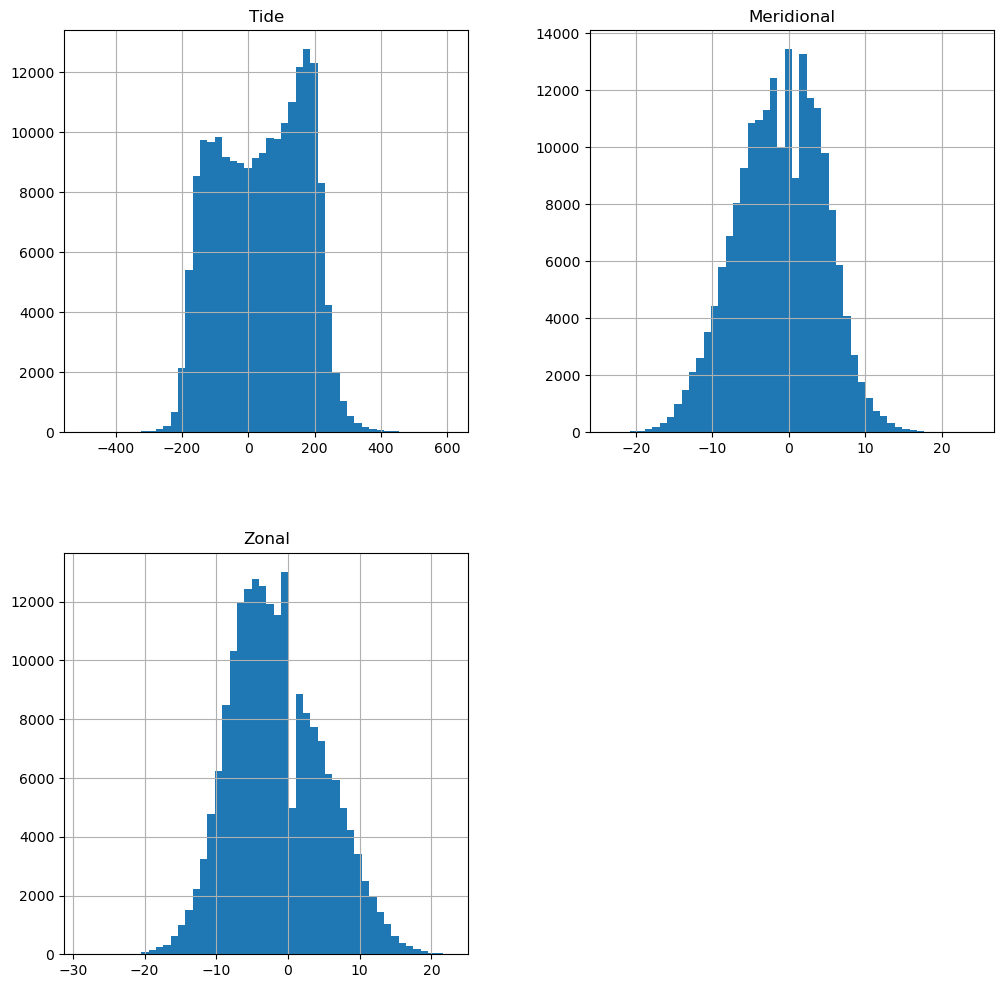

In [33]:
# Example: Plotting histograms of all numerical features
combined_df[combined_df.columns[1:4]].hist(figsize=(12, 12), bins=50)
plt.show()


## Possible Biases

A inherent bias in our dataset could stem from the underrepresentation of storm surges, potentially limiting the accuracy of our model's description. To mitigate this concern, we may consider implementing undersampling in future analyses. This approach could enhance our model's ability to capture and predict storm surge events more effectively. 

Furthermore, our model's performance with positive zonal wind values may be adversely affected compared to negative values, as evidenced by the mismatch between the number of positive and negative zonal wind speeds in the histogram. 

In [46]:
storm_surge = np.shape(np.where(combined_df[combined_df.columns[1]].values >= 363)[0])[0]
not_storm_surge = np.shape(np.where(combined_df[combined_df.columns[1]].values < 363)[0])[0]

print(f'Our dataset comprises {storm_surge} hours of storm surge water levels and {not_storm_surge} hours which don\'t belong to storm surges.')

Our dataset comprises 300 hours of storm surge water levels and 195385 hours which don't belong to storm surges.


It is important to note that a single storm surge event typically spans approximately 3 hours of exceptionally high water levels. Therefore, even within our dataset totaling 300 hours, we can expect to encounter roughly 100 distinct storm surge events.

## Correlations

We've observed that there aren't strong correlations between the meridional and zonal wind components, indicating that they don't encode redundant information. Additionally, a very weak correlation has been noted between water level and the zonal wind component This is exactly the connection we want to try and predict with our machine learning Model. 

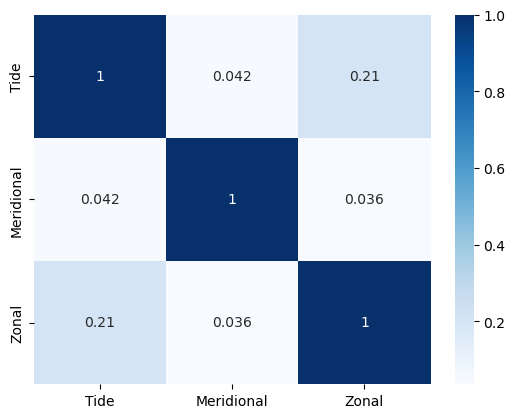

In [45]:
# Example: Plotting a heatmap to show feature correlations
correlation_matrix = abs(combined_df[combined_df.columns[1:4]].corr())
sns.heatmap(correlation_matrix, annot=True, cmap = 'Blues')
plt.show()
